In [1]:
# Import the data
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from encoders import build_encoders, encode
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE




# Read in the CSV
df = pd.read_csv("original dataset/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Explore the dataframe

In [2]:
# Check the shape of the dataframe
df.shape

(17880, 18)

In [3]:
# Display a quick summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
# Identify and count the missing values in the dataframe by column
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
# Identify and count the unique values in the dataframe by column
df.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11967
benefits                6204
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

In [6]:
# Review statistics for columns with numerical values
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


## Build the v1 Random Forest Model (baseline model with no filling or encoding)

In [7]:
# Make a copy the dataframe
df_baseline_1 = df.copy()

In [8]:
# Return a list of columns with object dtypes to drop
drop_strings = df_baseline_1.select_dtypes(include="object").columns.tolist()

# Append job_id to the the drop_strings list
drop_strings.append("job_id")

# Drop all object columns with the object dtype first and then any rows with na
df_baseline_1 = df_baseline_1.drop(drop_strings, axis=1).dropna()

In [9]:
# Check the shape of the dataframe
df_baseline_1.shape

(17880, 4)

In [10]:
# Split features and target
X = df_baseline_1.drop("fraudulent", axis=1)
y = df_baseline_1["fraudulent"]

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [12]:
# Create the random forest classifier instance
rf_baseline_model_1 = RandomForestClassifier(random_state=1, n_estimators=500)

In [13]:
# Fit the model
rf_baseline_model_1.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [14]:
# Make predictions using the testing data
predictions = rf_baseline_model_1.predict(X_test)

In [15]:
# Create a reusable function to sort features based on importance
def get_sorted_feature_importances(model, feature_names):
    importances = model.feature_importances_
    importances_sorted = sorted(zip(importances, feature_names), reverse=True)
    return importances, importances_sorted

In [16]:
# Call the function to sort features based on importance and print results
importances, importances_sorted = get_sorted_feature_importances(rf_baseline_model_1, X_train.columns)
print(importances_sorted)

[(0.8714201115150486, 'has_company_logo'), (0.10641782131665987, 'has_questions'), (0.02216206716829149, 'telecommuting')]


In [17]:
# Create a reusable function to plot the feature importances
def plot_feature_importances(X_train, importances):
    features = sorted(zip(X.columns, importances), key=lambda x: x[1])
    cols = [f[0] for f in features]
    width = [f[1] for f in features]

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    plt.margins(y=0.001)
    ax.barh(y=cols, width=width)
    plt.show()

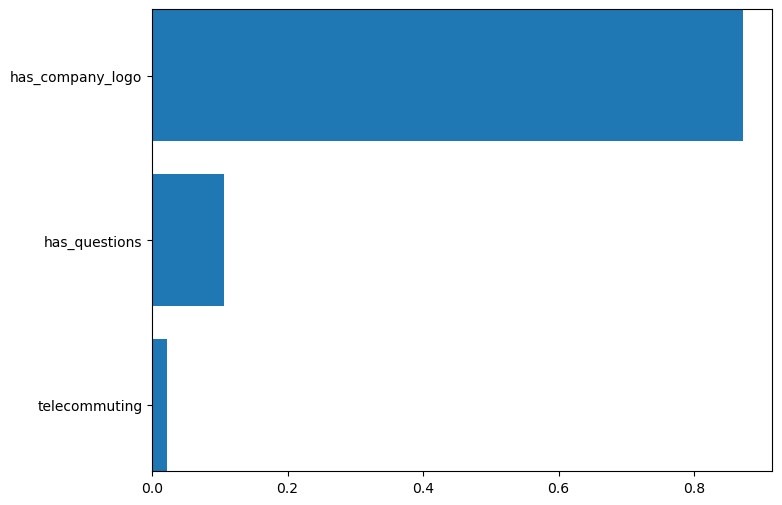

In [18]:
# Call the function to plot the feature importances
plot_feature_importances(X_train, importances)

In [19]:
# Evaluate the model accuracy for the training, testing and balanced scores
train_acc_1 = rf_baseline_model_1.score(X_train, y_train)
test_acc_1 = rf_baseline_model_1.score(X_test, y_test)
balanced_acc_1 = balanced_accuracy_score(y_test, predictions)


In [20]:
# Print the training, testing and balanced accuracy scores
print(f"Training Score: {train_acc_1:.3f}")
print(f"Testing Score: {test_acc_1:.3f}")
print(f"Balanced Accuracy Score: {balanced_acc_1:.3f}")

Training Score: 0.949
Testing Score: 0.958
Balanced Accuracy Score: 0.500


In [21]:
# Create a reusable function to plot the confusion matrix
def plot_confusion_matrix(y_true, predictions):
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

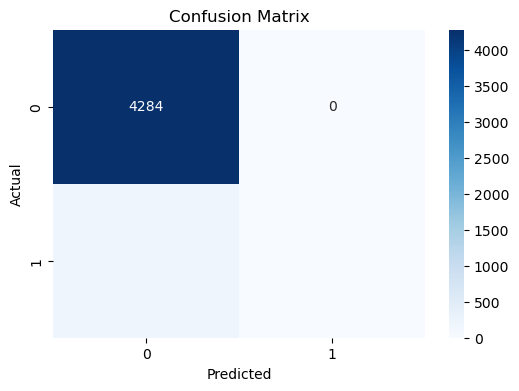

In [22]:
# Call function to plot the confusion matrix
plot_confusion_matrix(y_test, predictions)

In [23]:
# Print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4284
           1       0.00      0.00      0.00       186

    accuracy                           0.96      4470
   macro avg       0.48      0.50      0.49      4470
weighted avg       0.92      0.96      0.94      4470



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Build the v2 Random Forest Model (Minimal filling and encoding)

In [24]:
# Make a copy the dataframe
df_baseline_2 = df.copy()

In [25]:
# Define list of columns with minimal data or lots of unique values
columns_to_drop = ["job_id", "title", "location", "department", "salary_range", 
                   "company_profile", "description", "requirements", "benefits", "industry"]

# Drop columns from the copy of the data frame
df_baseline_2.drop(columns_to_drop, axis=1, inplace=True)

In [26]:
# Split features and target
X = df_baseline_2.drop("fraudulent", axis=1)
y = df_baseline_2["fraudulent"]

In [27]:
# List of the column names to fill with "unknown"
columns_to_fill = ["employment_type", "required_experience", "required_education", "function"]

# Fill the missing values 
for col in columns_to_fill:
    X[col] = X[col].fillna("unknown")

# Display the first few rows to verify the changes
print(X.head())

   telecommuting  has_company_logo  has_questions employment_type  \
0              0                 1              0           Other   
1              0                 1              0       Full-time   
2              0                 1              0         unknown   
3              0                 1              0       Full-time   
4              0                 1              1       Full-time   

  required_experience required_education              function  
0          Internship            unknown             Marketing  
1      Not Applicable            unknown      Customer Service  
2             unknown            unknown               unknown  
3    Mid-Senior level  Bachelor's Degree                 Sales  
4    Mid-Senior level  Bachelor's Degree  Health Care Provider  


In [28]:
# Create an instance of one hot encoders for "employement_type"
employment_type_encoder = OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist', sparse_output=False)

# Fit and transform the "employment_type" encoders
employment_type_encoded = employment_type_encoder.fit_transform(X["employment_type"].values.reshape(-1, 1))

# Replace the original "employement_type" column with the encoded values
X["employment_type"] = employment_type_encoded


In [29]:
# # Create an instance of one hot encoders for "required_experience"
required_experience_encoder = OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist', sparse_output=False)

# Fit and transform the "required_experience" encoders
required_experience_encoded = required_experience_encoder.fit_transform(X["required_experience"].values.reshape(-1, 1))

# Replace the original "required_experience" column with the encoded values
X["required_experience"] = required_experience_encoded

In [30]:
# Create an instance of one hot encoders for "required_education"
required_education_encoder = OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist', sparse_output=False)

# Fit and transform the required_education encoders
required_education_encoded = required_education_encoder.fit_transform(X["required_education"].values.reshape(-1, 1))

# Replace the original "required_education" column with the encoded values
X["required_education"] = required_education_encoded

In [31]:
# Create an instance of one hot encoders for "function"
function_encoder = OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist', sparse_output=False)

# Fit and transform the required_education encoders
function_encoded = function_encoder.fit_transform(X["function"].values.reshape(-1, 1))

# Replace the original "employement_type" column with the encoded values
X["function"] = function_encoded

In [32]:
# Create list of encoded feature names and their corresponding encoder names
columns_and_encoders = [
    ("employment_type", employment_type_encoder, employment_type_encoded),
    ("required_experience", required_experience_encoder, required_experience_encoded),
    ("required_education", required_education_encoder, required_education_encoded),
    ("function", function_encoder, function_encoded)
]
# Loop through each column and its encoder
for column, encoder, encoded_data in columns_and_encoders:
    
    # Get the feature names for the encoded columns
    encoded_feature_names = encoder.get_feature_names_out([column])
    
    # Create a DataFrame from the encoded data
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=X.index)
    
    # Drop the original column and concatenate the encoded DataFrame
    X = X.drop(column, axis=1).join(encoded_df)
X

,telecommuting,has_company_logo,has_questions,employment_type_Contract,employment_type_Full-time,employment_type_Part-time,employment_type_unknown,employment_type_infrequent_sklearn,required_experience_Associate,required_experience_Entry level,...,required_education_Bachelor's Degree,required_education_High School or equivalent,required_education_Unspecified,required_education_unknown,required_education_infrequent_sklearn,function_Engineering,function_Information Technology,function_Sales,function_unknown,function_infrequent_sklearn
0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
17876,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17877,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
17878,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [34]:
# Create the random forest classifier instance
rf_baseline_model_2 = RandomForestClassifier(random_state=1, n_estimators=500)

In [35]:
X_train

,telecommuting,has_company_logo,has_questions,employment_type_Contract,employment_type_Full-time,employment_type_Part-time,employment_type_unknown,employment_type_infrequent_sklearn,required_experience_Associate,required_experience_Entry level,...,required_education_Bachelor's Degree,required_education_High School or equivalent,required_education_Unspecified,required_education_unknown,required_education_infrequent_sklearn,function_Engineering,function_Information Technology,function_Sales,function_unknown,function_infrequent_sklearn
14808,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7580,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14112,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12879,0,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
755,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
17289,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5192,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12172,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
# Fit the model
rf_baseline_model_2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [37]:
# Make predictions using the testing data
predictions_2 = rf_baseline_model_2.predict(X_test)

In [38]:
# Call the function to sort features based on importance and print results
importances_2, importances_sorted_2 = get_sorted_feature_importances(rf_baseline_model_2, X_train.columns)
print(importances_sorted_2)

[(0.26816654730323675, 'has_company_logo'), (0.08175961290076067, 'has_questions'), (0.04672930952384224, 'function_infrequent_sklearn'), (0.042041545444858504, 'telecommuting'), (0.040615933754989814, 'employment_type_Part-time'), (0.03970049424367704, 'function_Engineering'), (0.039252727750213275, 'employment_type_Full-time'), (0.03836465411367148, 'required_experience_Entry level'), (0.03528172258759371, 'required_experience_unknown'), (0.03454774629891459, 'required_education_infrequent_sklearn'), (0.03406796792298366, 'required_experience_infrequent_sklearn'), (0.033664270603864635, 'required_education_High School or equivalent'), (0.03322869770652283, 'required_experience_Mid-Senior level'), (0.03261186813314798, 'function_unknown'), (0.029758004315490885, 'required_education_unknown'), (0.0269253067874056, "required_education_Bachelor's Degree"), (0.02472919470748883, 'employment_type_unknown'), (0.0241494142834593, 'function_Sales'), (0.023574606619783896, 'required_experience

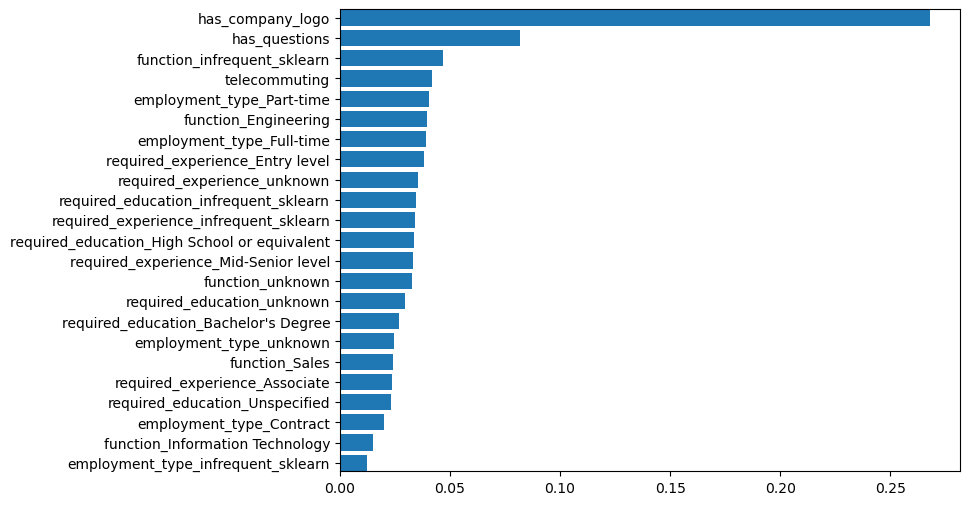

In [39]:
# Call the function to plot the feature importances
plot_feature_importances(X_train, importances_2)

In [40]:
# Evaluate the model accuracy for the training, testing and balanced scores
train_acc_2 = rf_baseline_model_2.score(X_train, y_train)
test_acc_2 = rf_baseline_model_2.score(X_test, y_test)
balanced_acc_2 = balanced_accuracy_score(y_test, predictions_2)


In [41]:
# Print the training, testing and balanced accuracy scores
print(f"Training Score: {train_acc_2:.3f}")
print(f"Testing Score: {test_acc_2:.3f}")
print(f"Balanced Accuracy Score: {balanced_acc_2:.3f}")

Training Score: 0.959
Testing Score: 0.960
Balanced Accuracy Score: 0.609


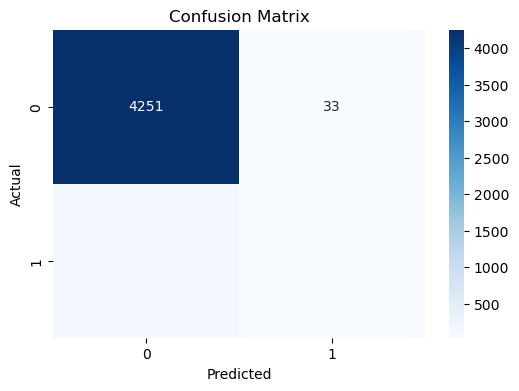

In [42]:
# Call function to plot the confusion matrix
plot_confusion_matrix(y_test, predictions_2)

In [43]:
# Print classification report
print(classification_report(y_test, predictions_2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4284
           1       0.56      0.23      0.32       186

    accuracy                           0.96      4470
   macro avg       0.76      0.61      0.65      4470
weighted avg       0.95      0.96      0.95      4470



## Build the v3 Random Forest Model (more sophisticated filling and encoding)

In [44]:
# Read in the formatted dataset
df_filled = pd.read_csv("formatted dataset/fake_job_postings.csv")
df_filled.head()

,job_id,title,country,state,city,department,salary_min,salary_max,company_profile,description,...,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,us,ny,new york,Marketing,-1.0,-1.0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",...,NaN,0,1,0,Other,Internship,Undefined,Undefined,Marketing,0
1,2,Customer Service - Cloud Video Production,nz,NaN,auckland,Success,-1.0,-1.0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Undefined,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),us,ia,wever,Undefined,-1.0,-1.0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",...,NaN,0,1,0,Undefined,Undefined,Undefined,Undefined,Undefined,0
3,4,Account Executive - Washington DC,us,dc,washington,Sales,-1.0,-1.0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,...,Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,us,fl,fort worth,Undefined,-1.0,-1.0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [45]:
# Make a copy the dataframe
df_baseline_3 = df_filled.copy()

In [46]:
# Define list of columns with minimal data or lots of unique values
columns_to_drop = ["job_id", "title", "company_profile", "description", "benefits"]

# Drop columns from the copy of the data frame
df_baseline_3.drop(columns_to_drop, axis=1, inplace=True)

In [47]:
# Split features and target
X = df_baseline_3.drop("fraudulent", axis=1)
y = df_baseline_3["fraudulent"]

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train

,country,state,city,department,salary_min,salary_max,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
14808,us,sc,greenville,Undefined,-1.0,-1.0,Education and Experience: · Electrical...,0,0,0,Full-time,Mid-Senior level,Unspecified,Machinery,Engineering
7580,us,fl,miami,Construction,196000.0,230000.0,Experience Welders.,0,0,0,Contract,Mid-Senior level,Bachelor's Degree,Construction,Other
14112,gb,lnd,london,Engineering,-1.0,-1.0,Good working knowledge of Python or similar la...,0,1,0,Undefined,Undefined,Undefined,Undefined,Engineering
12879,us,ny,rye,4,-1.0,-1.0,Must be self-motivated with strong verbal and ...,0,1,1,Full-time,Associate,High School or equivalent,Banking,Customer Service
755,us,oh,ashland,Undefined,-1.0,-1.0,University degree required. TEFL / TESOL / CEL...,0,1,1,Contract,Undefined,Bachelor's Degree,Education Management,Undefined
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,gb,lnd,london,Undefined,-1.0,-1.0,About YouYou must have previous customer servi...,0,1,0,Full-time,Undefined,Undefined,Consumer Goods,Customer Service
17289,il,NaN,NaN,Undefined,-1.0,-1.0,You have to love QA and feel a compulsion to t...,0,0,1,Full-time,Undefined,Undefined,Undefined,Undefined
5192,gb,NaN,NaN,Undefined,-1.0,-1.0,HGV/LGV Class 1 license.Digi Tacho.,0,1,1,Undefined,Undefined,Undefined,Undefined,Undefined
12172,us,fl,daytona,Undefined,-1.0,-1.0,Experience in programming microcontrollersEmbe...,0,0,0,Full-time,Undefined,Undefined,Undefined,Undefined


In [49]:
# Encode and transform the training and testing X data
encoders_3 = build_encoders(X_train)
X_train_encoded_3 = encode(X_train, encoders_3)
X_test_encoded_3 = encode(X_test, encoders_3)
X_test_encoded_3

,salary_min,salary_max,telecommuting,has_company_logo,has_questions,x0_gb,x0_gr,x0_us,x0_infrequent_sklearn,x0_ca,...,x0_Administrative,x0_Customer Service,x0_Design,x0_Engineering,x0_Health Care Provider,x0_Information Technology,x0_Marketing,x0_Sales,x0_Undefined,x0_infrequent_sklearn
0,-1.0,-1.0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.0,-1.0,0,1,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,90000.0,100000.0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.0,-1.0,0,1,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.0,-1.0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,-1.0,-1.0,0,1,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4466,-1.0,-1.0,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4467,-1.0,-1.0,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4468,-1.0,-1.0,0,1,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [50]:
# Create the random forest classifier instance
rf_baseline_model_3 = RandomForestClassifier(random_state=1, n_estimators=500)

In [51]:
# Fit the model
rf_baseline_model_3.fit(X_train_encoded_3, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [52]:
# Make predictions using the testing data
predictions_3 = rf_baseline_model_3.predict(X_test_encoded_3)

In [53]:
# Call the function to sort features based on importance and print results
importances_3, importances_sorted_3 = get_sorted_feature_importances(rf_baseline_model_3, X_train_encoded_3.columns)
print(importances_sorted_3)

[(0.10520580289393777, 'has_company_logo'), (0.05255860664620468, 'salary_max'), (0.04754207613090988, 'has_questions'), (0.04587778469747336, 'salary_min'), (0.03496140209594007, 'x0_Administrative'), (0.026991408384486743, 'x0_infrequent_sklearn'), (0.026813998111638933, 'x0_Full-time'), (0.025556905579708272, 'x0_High School or equivalent'), (0.024506531079036113, 'x0_infrequent_sklearn'), (0.02331437406687675, 'x0_houston'), (0.023271642477090765, 'x0_Part-time'), (0.022581562087253485, 'x0_Undefined'), (0.022516265128525257, 'x0_infrequent_sklearn'), (0.022259178345382862, 'x0_infrequent_sklearn'), (0.022165495431336096, 'x0_Mid-Senior level'), (0.020481542012441952, 'x0_Engineering'), (0.02047233283657471, 'x0_Undefined'), (0.01993377770383184, 'x0_Entry level'), (0.019198409088325107, 'x0_ca'), (0.01887673649068033, "x0_Bachelor's Degree"), (0.0186861174711381, 'x0_nan'), (0.0186851750904068, 'x0_us'), (0.016726003626883663, 'x0_tx'), (0.016372464453861424, 'x0_Hospital & Health

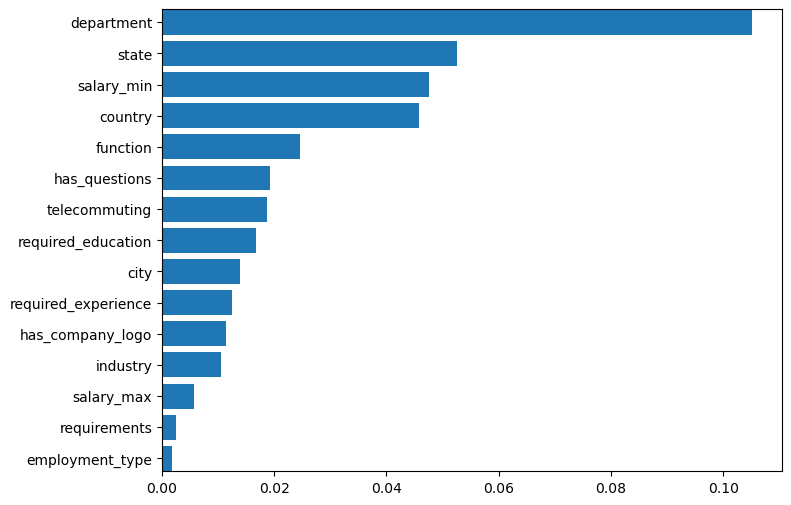

In [54]:
# Call the function to plot the feature importances
plot_feature_importances(X_train_encoded_3, importances_3)

In [55]:
# Evaluate the model accuracy for the training, testing and balanced scores
train_acc_3 = rf_baseline_model_3.score(X_train_encoded_3, y_train)
test_acc_3 = rf_baseline_model_3.score(X_test_encoded_3, y_test)
balanced_acc_3 = balanced_accuracy_score(y_test, predictions_3)

In [56]:
# Print the training, testing and balanced accuracy scores
print(f"Training Score: {train_acc_3:.3f}")
print(f"Testing Score: {test_acc_3:.3f}")
print(f"Balanced Accuracy Score: {balanced_acc_3:.3f}")

Training Score: 0.988
Testing Score: 0.975
Balanced Accuracy Score: 0.774


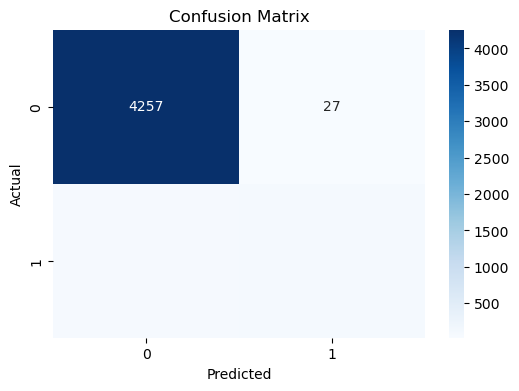

In [57]:
# Call function to plot the confusion matrix
plot_confusion_matrix(y_test, predictions_3)

In [58]:
# Print classification report
print(classification_report(y_test, predictions_3))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.79      0.55      0.65       186

    accuracy                           0.98      4470
   macro avg       0.89      0.77      0.82      4470
weighted avg       0.97      0.98      0.97      4470



## Build the Final Random Forest Model (hypertuned parameters and oversampled)

In [59]:
# Make a copy the dataframe
df_baseline_4 = df_filled.copy()

In [60]:
# Define list of columns with minimal data or lots of unique values
columns_to_drop = ["job_id", "title", "company_profile", "description", "benefits"]

# Drop columns from the copy of the data frame
df_baseline_4.drop(columns_to_drop, axis=1, inplace=True)

In [61]:
# Split features and target
X = df_baseline_4.drop("fraudulent", axis=1)
y = df_baseline_4["fraudulent"]

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [63]:
# Encode and transform the training and testing X data
encoders_4 = build_encoders(X_train)
X_train_encoded_4 = encode(X_train, encoders_4)
X_test_encoded_4 = encode(X_test, encoders_4)
X_test_encoded_4


,salary_min,salary_max,telecommuting,has_company_logo,has_questions,x0_gb,x0_gr,x0_us,x0_infrequent_sklearn,x0_ca,...,x0_Administrative,x0_Customer Service,x0_Design,x0_Engineering,x0_Health Care Provider,x0_Information Technology,x0_Marketing,x0_Sales,x0_Undefined,x0_infrequent_sklearn
0,-1.0,-1.0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.0,-1.0,0,1,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,90000.0,100000.0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.0,-1.0,0,1,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.0,-1.0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,-1.0,-1.0,0,1,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4466,-1.0,-1.0,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4467,-1.0,-1.0,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4468,-1.0,-1.0,0,1,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
# Apply SMOTE to oversample the training data
smote = SMOTE(random_state=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded_4, y_train)

In [65]:
# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 1000),
    "max_features": ["sqrt", "log2"],
    "max_depth": randint(4, 10),
    "criterion": ["gini", "entropy"]
}

In [66]:
# Create a base model
rf_baseline_model_4 = RandomForestClassifier()

In [67]:
# Instantiate the random search model
random_search = RandomizedSearchCV(estimator=rf_baseline_model_4, param_distributions=param_dist, 
                                   n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=1, scoring="accuracy")

In [68]:
# Fit the random search to the data
random_search.fit(X_train_balanced, y_train_balanced)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16904d1d0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x161b91bd0>},
                   random_state=1, scoring='accuracy', verbose=2)

In [69]:
# Print the best parameters and best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 669}
Best score: 0.9346035027364316


In [70]:
# Use the best model found
final_rf_model = random_search.best_estimator_

# Make predictions using the recommended model
predictions_4 = final_rf_model.predict(X_test_encoded_4)

In [71]:
# Evaluate the model accuracy for the training, testing and balanced scores
train_acc_final = final_rf_model.score(X_train_balanced, y_train_balanced)
test_acc_final = final_rf_model.score(X_test_encoded_4, y_test)
balanced_acc_final = balanced_accuracy_score(y_test, predictions_4)


In [72]:
# Print the training, testing and balanced accuracy scores
print(f"Training Score: {train_acc_final:.3f}")
print(f"Testing Score: {test_acc_final:.3f}")
print(f"Balanced Accuracy Score: {balanced_acc_final:.3f}")

Training Score: 0.937
Testing Score: 0.897
Balanced Accuracy Score: 0.841


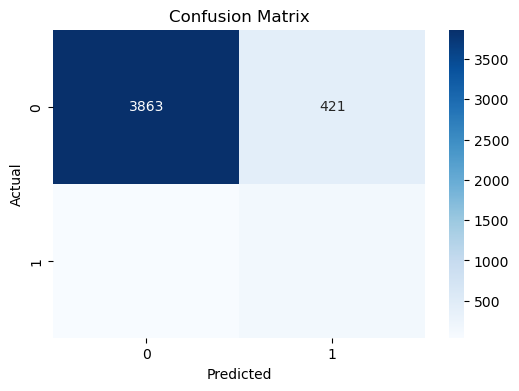

In [73]:
# Call function to plot the confusion matrix
plot_confusion_matrix(y_test, predictions_4)

In [74]:
# Print classification report
print(classification_report(y_test, predictions_4))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4284
           1       0.26      0.78      0.39       186

    accuracy                           0.90      4470
   macro avg       0.62      0.84      0.66      4470
weighted avg       0.96      0.90      0.92      4470

